In [2]:
import pyAMARES
import numpy as np

pyAMARES.__version__

'0.3.23dev'

# Fitting Simulated In Vivo 31P MRS Data
**[Try This Tutorial on Google Colab!](https://colab.research.google.com/drive/1H8GdP4XX292JovAF5TNOEBaYQT5vk_DT)**

## Simulating an In Vivo MRS Spectrum

- **Load Prior Knowledge**: Use the dataset based on the 7T brain data reported by Ren et al. in NMR Biomedicine, 28(11): 1455–1462.

Warning, fid is None!
Checking comment lines in the prior knowledge file
Comment: in line 0 "#  Ren et al, NMR Biomed . 2015 Nov;28(11):1455-62. doi: 10.1002/nbm.3384.",,,,,,,,,,,,,,,,

Comment: in line 14 # Use the same phase for all peaks,,,,,,,,,,,,,,,,

Comment: in line 15 " # 2024/06/24 In Ren et al, the chemical shift range of BATP (0.1 ppm), AATP (0.04 ppm), and GATP (0.02 ppm) are smaller than the J-couplin range (0.125 - 0.25 ppm). ",,,,,,,,,,,,,,,,

Comment: in line 16 "# So, increase the chemical shift range",,,,,,,,,,,,,,,,



/home/xujia/gitlab/pyAMARES/pyAMARES/kernel/PriorKnowledge.py:314: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pk = pk.applymap(
/home/xujia/gitlab/pyAMARES/pyAMARES/kernel/PriorKnowledge.py:315: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  lambda x: pd.to_numeric(x, errors="ignore")
/home/xujia/gitlab/pyAMARES/pyAMARES/kernel/PriorKnowledge.py:86: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


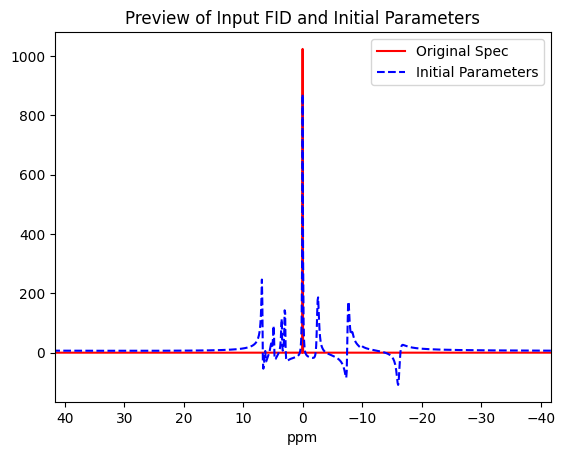

Printing the Prior Knowledge File example_human_brain_31P_7T.csv


,BATP,BATP2,BATP3,AATP,AATP2,GATP,GATP2,UDPG,NAD,PCr,GPC,GPE,Pin,Pex,PC,PE
Index,,,,,,,,,,,,,,,,
Initial Values,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,1.41,BATP/2,BATP/2,1.545,AATP,1.5,GATP,0.08,0.41,4.37,1.32,0.8,0.85,0.3,0.3,2.27
chemicalshift,-16.15,BATP-15Hz,BATP+15Hz,-7.49,AATP-16Hz,-2.46,GATP-16Hz,-9.72,-8.25,0,2.95,3.5,4.82,5.24,6.24,6.76
linewidth,58.12,BATP,BATP,32.28,AATP,39.02,GATP,32.37,40.49,15.41,19.96,19.1,21.04,30.91,19.96,22.63
phase,0,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP,BATP
g,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,"(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,"
chemicalshift,"(-16.30,-16.00)","(-16.30,-16.00)","(-16.30,-16.00)","(-7.72,-7.42)","(-7.72,-7.42)","(-2.65,-2.39)","(-2.65,-2.39)","(-9.76,-9.68)","(-8.25,-8.17)","(-0.5, 0.5)","(2.94,2.96)","(3.49,3.51)","(4.81,4.83)","(5.19,5.29)","(6.22,6.26)","(6.71,6.81)"


In [5]:
priorknowledge = pyAMARES.initialize_FID(
    fid=None, priorknowledgefile="example_human_brain_31P_7T.csv", preview=True
)

- **Perturb Peak Parameters**: Randomly adjust the 31P spectra peak parameters by 5%, chemical shift by 10 Hz

In [6]:
from copy import deepcopy

In [7]:
params0 = deepcopy(
    priorknowledge.initialParams
)  # Make a copy of initialParams to be perturbed

In [8]:
def perturb_value(value, percentage=5):
    percentage = float(percentage)
    # Generate a random perturbation factor between 0.95 and 1.05
    factor = np.random.uniform(1 - percentage / 100, 1 + percentage / 100)
    # Apply the perturbation factor
    result = value * factor
    # print(f"Perturbing input {value=} to {result=}")
    return result


def perturb_table(inputparams, percentage=5, freq_shift=5, phase_shift=0):
    params = deepcopy(inputparams)
    for i in params:
        if params[i].name.startswith("ak") or params[i].name.startswith("dk"):
            params[i].value = perturb_value(params[i].value)
        if params[i].name.startswith("freq"):
            params[i].value += np.random.uniform(-freq_shift, freq_shift)
        if params[i].name.startswith("phi"):
            params[i].value += np.random.uniform(
                -np.deg2rad(phase_shift), np.deg2rad(phase_shift)
            )
    return params

In [9]:
params = perturb_table(params0, percentage=5, freq_shift=5, phase_shift=0)

- **Simulate the 31P MRS Spectra Using Scanner Parameters**:
    - **MHz (Field Strength)**: 120 MHz, corresponding to 31P at 7T.
    - **sw (Spectral Width)**: 10000.0 Hz.
    - **Deadtime**: 200 microseconds (200e-6 seconds).
    - **Number of Points (fid_len)**: 1024.
    - **SNR (Signal to Noise Ratio, snr_target)**: 20.

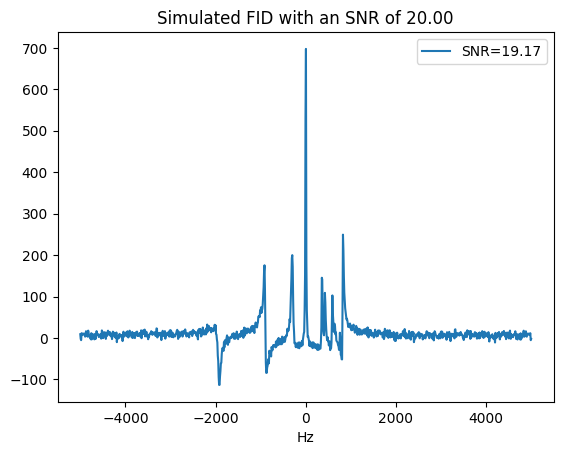

In [10]:
fid = pyAMARES.kernel.fid.simulate_fid(
    params,
    MHz=120.0,
    sw=10000.0,
    deadtime=200e-6,
    fid_len=1024,
    snr_target=20,
    preview=True,
)

## Simple Tutorial on pyAMARES Fitting
- **Initialize the FID Object**: 

In [12]:
FIDobj = pyAMARES.initialize_FID(
    fid=fid,
    MHz=120.0,
    sw=10000.0,
    deadtime=200e-6,
    normalize_fid=False,
    priorknowledgefile="example_human_brain_31P_7T.csv",
    preview=False,
)

Checking comment lines in the prior knowledge file
Comment: in line 0 "#  Ren et al, NMR Biomed . 2015 Nov;28(11):1455-62. doi: 10.1002/nbm.3384.",,,,,,,,,,,,,,,,

Comment: in line 14 # Use the same phase for all peaks,,,,,,,,,,,,,,,,

Comment: in line 15 " # 2024/06/24 In Ren et al, the chemical shift range of BATP (0.1 ppm), AATP (0.04 ppm), and GATP (0.02 ppm) are smaller than the J-couplin range (0.125 - 0.25 ppm). ",,,,,,,,,,,,,,,,

Comment: in line 16 "# So, increase the chemical shift range",,,,,,,,,,,,,,,,



/home/xujia/gitlab/pyAMARES/pyAMARES/kernel/PriorKnowledge.py:314: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pk = pk.applymap(
/home/xujia/gitlab/pyAMARES/pyAMARES/kernel/PriorKnowledge.py:315: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  lambda x: pd.to_numeric(x, errors="ignore")
/home/xujia/gitlab/pyAMARES/pyAMARES/kernel/PriorKnowledge.py:86: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


- **A. HSVD Optimization of Initial Parameters (Optional)**: Utilize HSVD to optimize the initial parameters for fitting, if desired.

Norm of residual = 69.617
Norm of the data = 2652.205
resNormSq / dataNormSq = 0.026


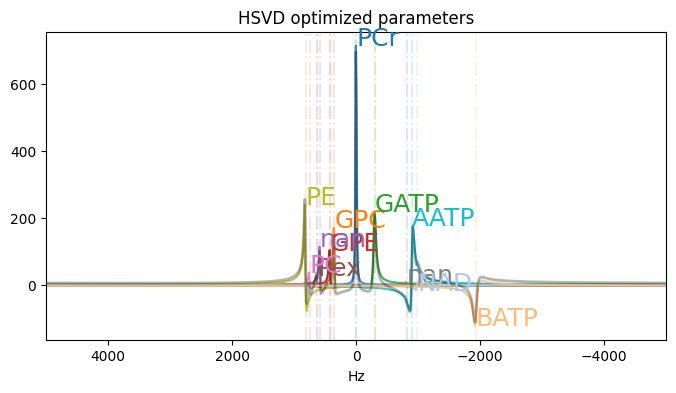

In [13]:
params_hsvd = pyAMARES.HSVDinitializer(
    fid_parameters=FIDobj,
    num_of_component=12,  # If an error happens with preview, decrease this number
    fitting_parameters=FIDobj.initialParams,
    preview=False,
)

- **Fitting AMARES Using HSVD-Initialized Parameters**:

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 3.276e-06
Fitting with method=least_squares took 1.564019 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.
It seems that zeros are padded after 1024
Remove padded zeros from residual estimation!
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 342
Reduced chi-squared (redchi): 0.03424234898722308
Fit success status: Success
Fit message: `ftol` termination condition is satisfied.
Norm of residual = 68.861
Norm of the data = 2652.205
resNormSq / dataNormSq = 0.026


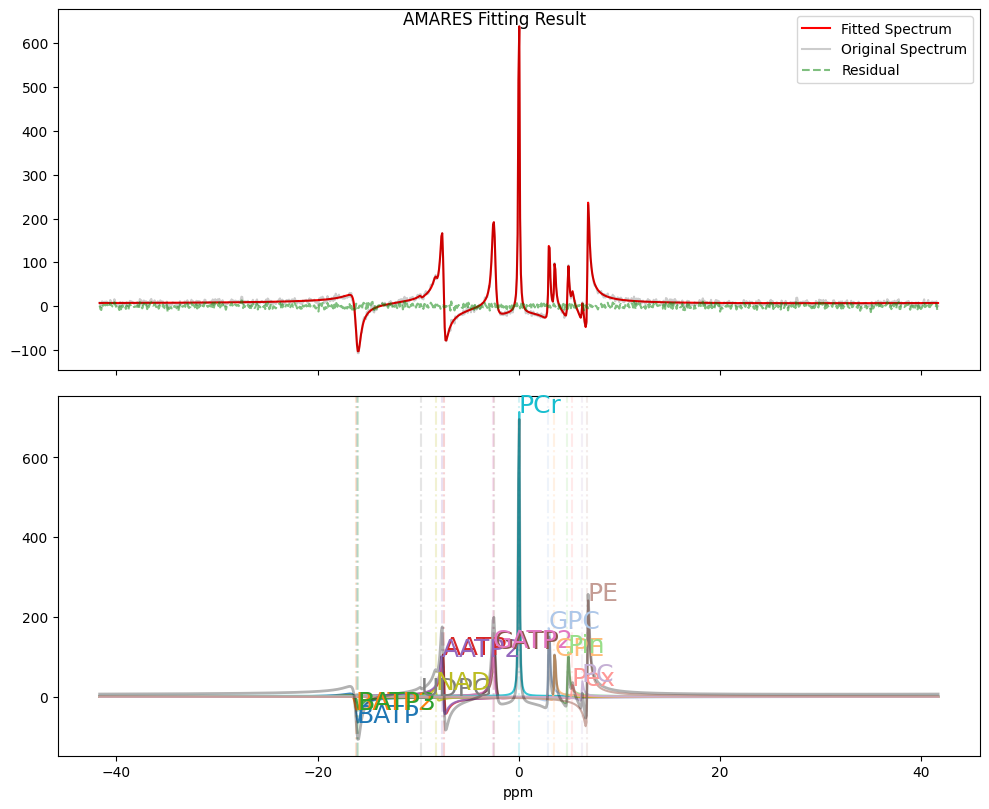

In [14]:
FIDresult1 = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=params_hsvd,
    method="least_squares",
    ifplot=True,
    inplace=False,
)

In [15]:
FIDresult1.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%),SNR
name,,,,,,,,,,,,,,,,
BATP,2.865,0.058,2.807,-16.111,0.007,0.046,60.226,1.886,4.299,-0.419,0.301,100.673,0.000,0.000,nan,10.333
AATP,3.111,0.054,2.409,-7.478,0.002,0.044,32.741,0.911,3.883,-0.419,0.301,100.673,0.000,0.000,nan,11.222
GATP,3.219,0.047,2.047,-2.432,0.003,0.158,39.060,0.932,3.331,-0.419,0.301,100.673,0.000,0.000,nan,11.612
UDPG,0.060,0.037,86.460,-9.757,0.072,1.026,29.125,24.940,119.523,-0.419,0.301,100.673,0.000,0.000,nan,0.216
NAD,0.414,0.060,20.270,-8.238,0.022,0.367,46.155,8.419,25.461,-0.419,0.301,100.673,0.000,0.000,nan,1.492
PCr,4.236,0.026,0.853,-0.032,0.000,2.194,14.957,0.128,1.197,-0.419,0.301,100.673,0.000,0.000,nan,15.281
GPC,1.394,0.032,3.195,2.944,0.002,0.091,20.855,0.660,4.416,-0.419,0.301,100.673,0.000,0.000,nan,5.028
GPE,0.783,0.031,5.513,3.505,0.003,0.121,19.487,1.062,7.605,-0.419,0.301,100.673,0.000,0.000,nan,2.823
Pin,0.897,0.038,5.885,4.830,0.003,0.090,21.386,1.164,7.596,-0.419,0.301,100.673,0.000,0.000,nan,3.235


- **B. Initialization Using Levenberg-Marquardt Method**: Instead of using the HSVD initializer, initialize the parameters using the Levenberg-Marquardt method.

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 3.276e-06
Fitting with method=leastsq took 0.699101 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.
a_sd is all None, use crlb instead!
freq_sd is all None, use crlb instead!
lw_sd is all None, use crlb instead!
phase_sd is all None, use crlb instead!
g_std is all None, use crlb instead!
It seems that zeros are padded after 1024
Remove padded zeros from residual estimation!
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 385
Reduced chi-squared (redchi): 0.04289376700948588
Fit success status: Success
Fit message: Fit succeeded. Could not estimate error-bars.
Norm of residual = 86.259
Norm of the data = 2652.205
resNormSq / dataNormSq = 0.033


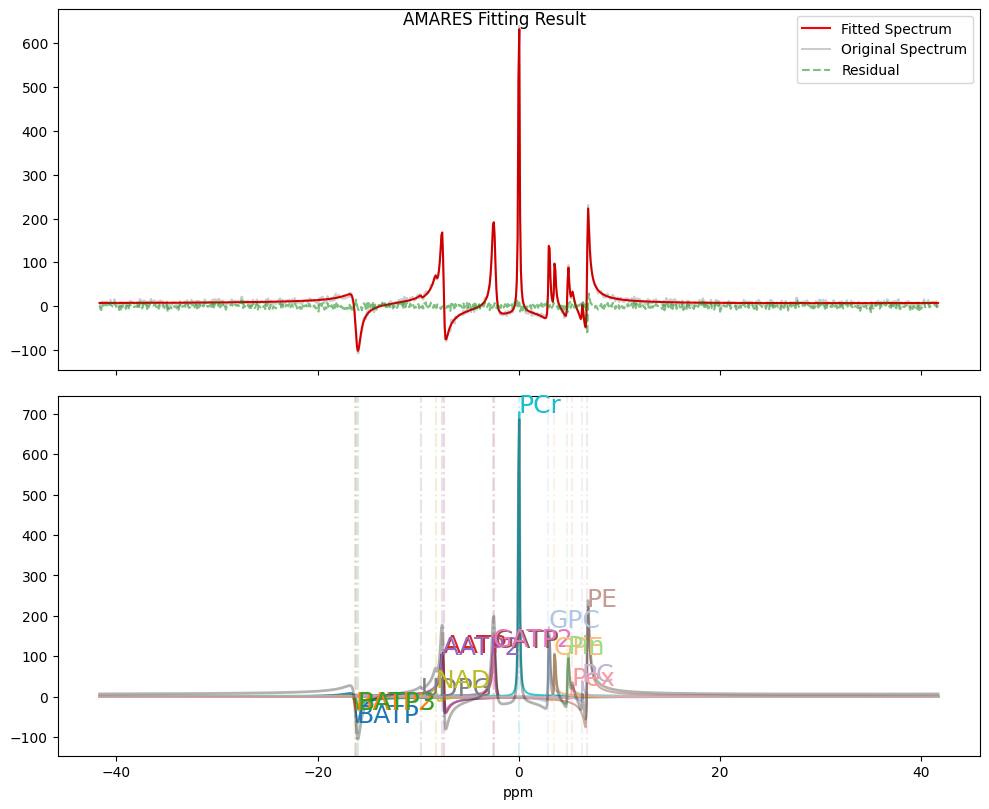

In [16]:
params_LM = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=FIDobj.initialParams,
    method="leastsq",
    ifplot=True,
    inplace=False,
)

- **Fitting AMARES Using Levenberg-Marquardt-Initialized Parameters**:

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 3.276e-06
Fitting with method=least_squares took 1.271048 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.
It seems that zeros are padded after 1024
Remove padded zeros from residual estimation!
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 266
Reduced chi-squared (redchi): 0.03424234897552882
Fit success status: Success
Fit message: `ftol` termination condition is satisfied.
Norm of residual = 68.861
Norm of the data = 2652.205
resNormSq / dataNormSq = 0.026


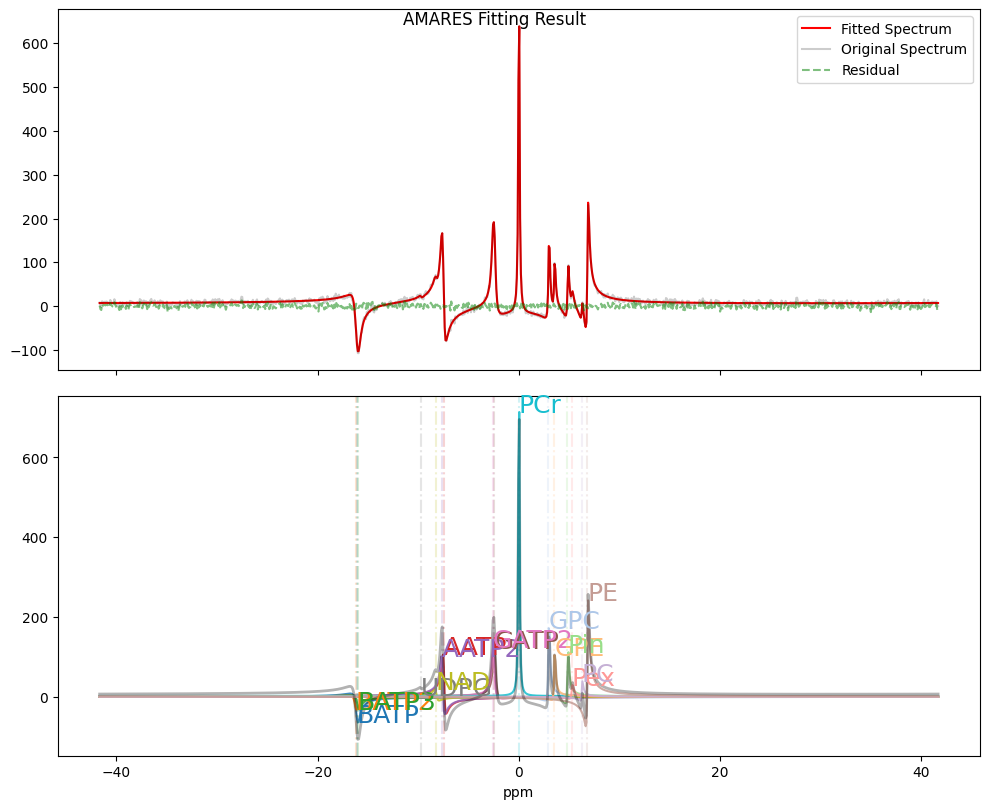

In [17]:
FIDresult2 = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=params_LM.fittedParams,
    initialize_with_lm=False,
    method="least_squares",
    ifplot=True,
    inplace=False,
)

In [18]:
FIDresult2.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%),SNR
name,,,,,,,,,,,,,,,,
BATP,2.865,0.058,2.807,-16.111,0.007,0.046,60.226,1.886,4.299,-0.419,0.301,100.671,0.000,0.000,nan,10.333
AATP,3.111,0.054,2.409,-7.478,0.002,0.044,32.741,0.911,3.883,-0.419,0.301,100.671,0.000,0.000,nan,11.222
GATP,3.219,0.047,2.047,-2.432,0.003,0.158,39.060,0.932,3.331,-0.419,0.301,100.671,0.000,0.000,nan,11.612
UDPG,0.060,0.037,86.460,-9.757,0.072,1.026,29.125,24.940,119.523,-0.419,0.301,100.671,0.000,0.000,nan,0.216
NAD,0.414,0.060,20.270,-8.238,0.022,0.367,46.155,8.419,25.461,-0.419,0.301,100.671,0.000,0.000,nan,1.492
PCr,4.236,0.026,0.853,-0.032,0.000,2.194,14.957,0.128,1.197,-0.419,0.301,100.671,0.000,0.000,nan,15.281
GPC,1.394,0.032,3.195,2.944,0.002,0.091,20.855,0.660,4.416,-0.419,0.301,100.671,0.000,0.000,nan,5.028
GPE,0.783,0.031,5.513,3.505,0.003,0.121,19.487,1.062,7.605,-0.419,0.301,100.671,0.000,0.000,nan,2.823
Pin,0.897,0.038,5.885,4.830,0.003,0.090,21.386,1.164,7.596,-0.419,0.301,100.671,0.000,0.000,nan,3.235


- **New after 0.3.10**: Fitting AMARES using internally initialized Levenberg-Marquardt parameters:

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 3.276e-06
Run internal leastsq initializer to optimize fitting parameters for the next least_squares fitting
Fitting with method=leastsq took 0.757242 seconds
Fitting with method=least_squares took 1.192739 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.
It seems that zeros are padded after 1024
Remove padded zeros from residual estimation!
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 266
Reduced chi-squared (redchi): 0.03424234897552882
Fit success status: Success
Fit message: `ftol` termination condition is satisfied.
Norm of residual = 68.861
Norm of the data = 2652.205
resNormSq / dataNormSq = 0.026


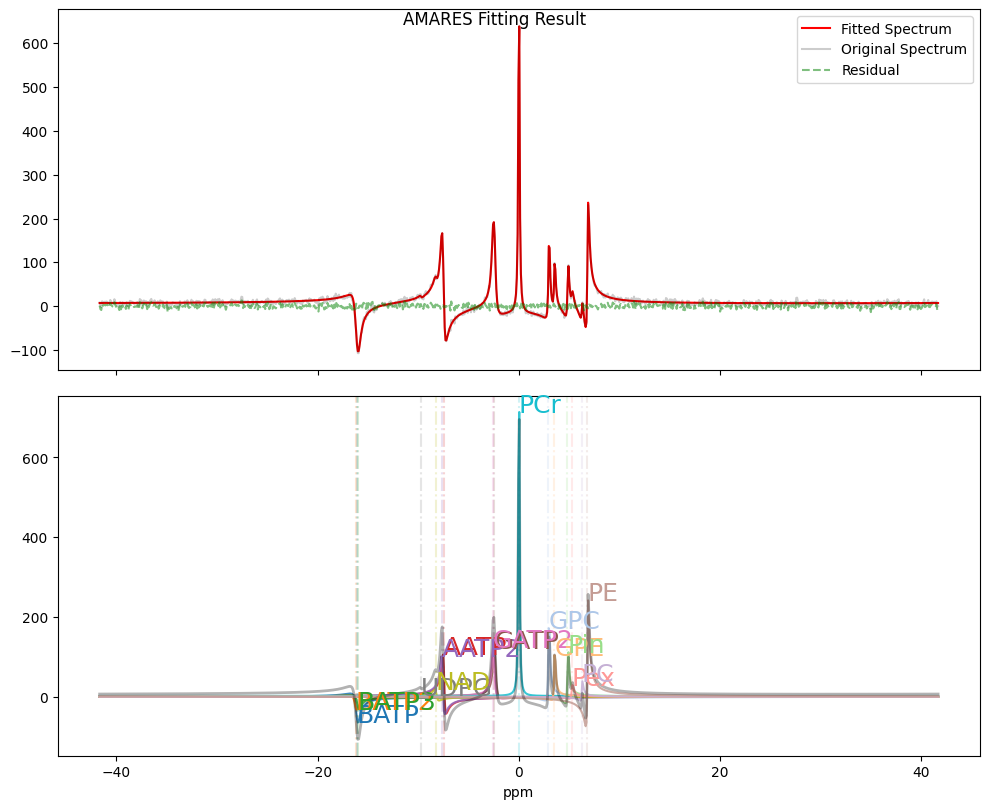

In [19]:
FIDresult2b = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=FIDobj.initialParams,
    initialize_with_lm=True,  # Turn on the Levenberg-Marquardt initializer
    method="least_squares",
    ifplot=True,
    inplace=False,
)

In [20]:
FIDresult2b.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%),SNR
name,,,,,,,,,,,,,,,,
BATP,2.865,0.058,2.807,-16.111,0.007,0.046,60.226,1.886,4.299,-0.419,0.301,100.671,0.000,0.000,nan,10.333
AATP,3.111,0.054,2.409,-7.478,0.002,0.044,32.741,0.911,3.883,-0.419,0.301,100.671,0.000,0.000,nan,11.222
GATP,3.219,0.047,2.047,-2.432,0.003,0.158,39.060,0.932,3.331,-0.419,0.301,100.671,0.000,0.000,nan,11.612
UDPG,0.060,0.037,86.460,-9.757,0.072,1.026,29.125,24.940,119.523,-0.419,0.301,100.671,0.000,0.000,nan,0.216
NAD,0.414,0.060,20.270,-8.238,0.022,0.367,46.155,8.419,25.461,-0.419,0.301,100.671,0.000,0.000,nan,1.492
PCr,4.236,0.026,0.853,-0.032,0.000,2.194,14.957,0.128,1.197,-0.419,0.301,100.671,0.000,0.000,nan,15.281
GPC,1.394,0.032,3.195,2.944,0.002,0.091,20.855,0.660,4.416,-0.419,0.301,100.671,0.000,0.000,nan,5.028
GPE,0.783,0.031,5.513,3.505,0.003,0.121,19.487,1.062,7.605,-0.419,0.301,100.671,0.000,0.000,nan,2.823
Pin,0.897,0.038,5.885,4.830,0.003,0.090,21.386,1.164,7.596,-0.419,0.301,100.671,0.000,0.000,nan,3.235


## Visualize Fitting Results

- **Visualization with pyAMARES**: pyAMARES utilizes the `plotParameter` object to display fitting results visually.
- **Template for `plotParameter`**: Within the initialized `FIDobj`, there is a pre-configured template for `plotParameter` to facilitate customization and usage.

In [21]:
plotParameter = (
    FIDobj.plotParameters
)  # plotParameter is a pointer to FIDobj.plotParameters
# If you do not want to modify FIDobj.plotParameters,
# do plotParameter = deepcopy(FIDobj.plotParameters) instead
plotParameter

Namespace(deadtime=0.0002, lb=2.0, sw=10000.0, xlim=None, ifphase=False)

- **Modify the visualization parameters**

In [22]:
plotParameter.ifphase = True  # Phasing the spectrum for visualization
plotParameter.xlim = (10, -20)  # Show 10 to -20 ppm only

fitting_parameters is None, just use the fid_parameters.out_obj.params


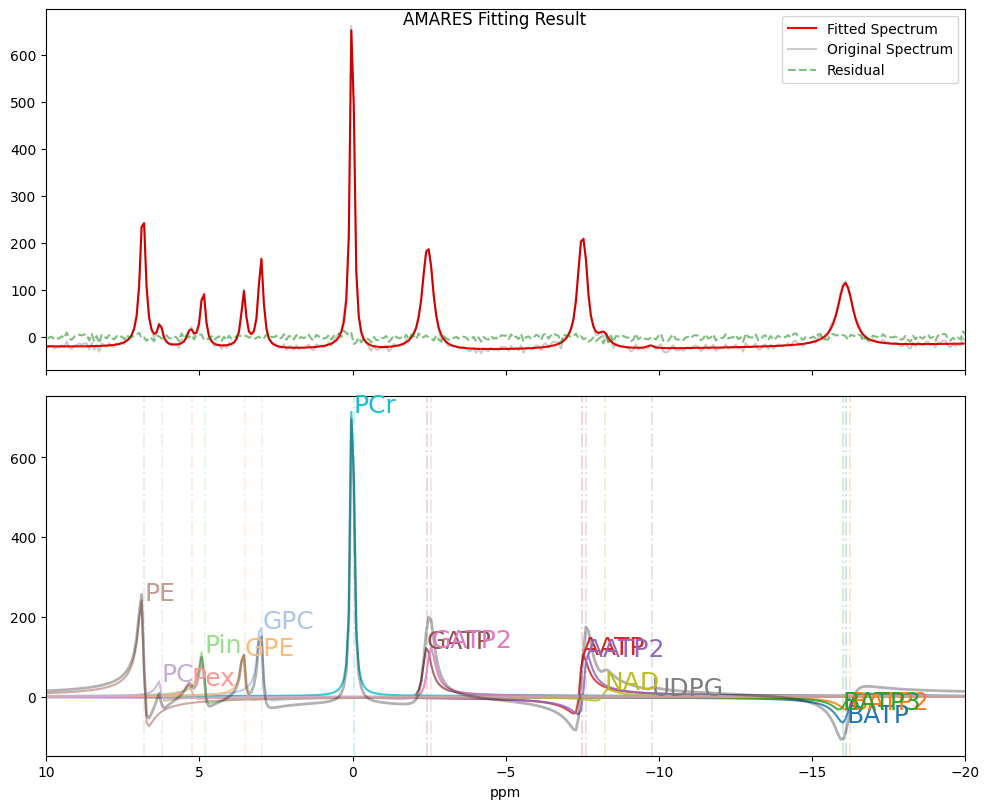

In [23]:
pyAMARES.plotAMARES(FIDresult2, plotParameters=plotParameter)

- **Uniform Phase for All Peaks**: Previously, each peak's phase was fitted independently. We can now attempt to use the same phase for all peaks.
- **Editing Parameters**: Parameters can be edited programmatically using Python. Alternatively, you can manually edit them using Excel or similar software. Use the `pyAMARES.kernel.lmfit.save_parameter_to_csv` function to save parameters to a CSV file, and `pyAMARES.kernel.lmfit.load_parameter_from_csv` to reload them as an lmfit parameter object.
``

In [24]:
initial_params_fixedphase = deepcopy(
    params_LM.fittedParams
)  # Starting from the Levenberg-Marquardt-Initialized Parameters

In [25]:
# Constrain all phase parameters (starting with `phi` ) to the phase of PCr (`phi_Pcr`)
for peak_para in initial_params_fixedphase:
    if peak_para.startswith("phi"):
        initial_params_fixedphase[peak_para].expr = "phi_PCr"

In [26]:
# But do not fix phi_PCr itself because it will be fitted
initial_params_fixedphase["phi_PCr"].expr = None
initial_params_fixedphase["phi_PCr"].vary = True

- If you modified the `FIDobj.plotParameters` above and turned on `ifphase`, the following preview will show phased spectrum

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 3.276e-06
Fitting with method=least_squares took 1.202114 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.
It seems that zeros are padded after 1024
Remove padded zeros from residual estimation!
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 266
Reduced chi-squared (redchi): 0.03424234897552957
Fit success status: Success
Fit message: `ftol` termination condition is satisfied.
Norm of residual = 68.861
Norm of the data = 2652.205
resNormSq / dataNormSq = 0.026


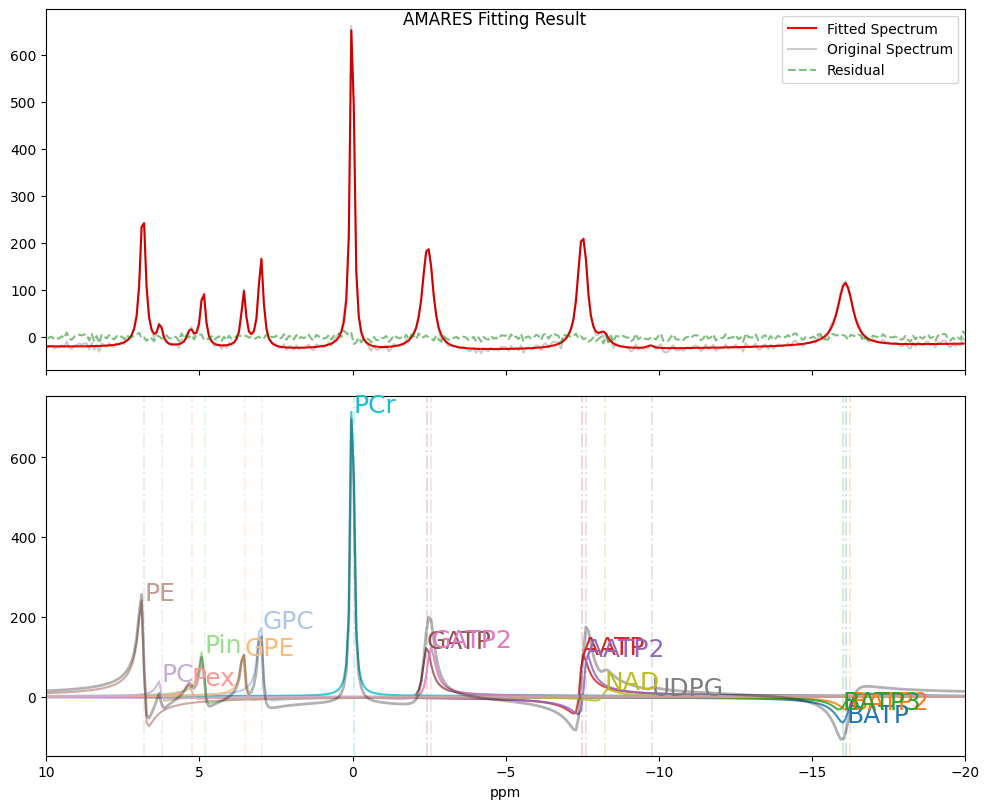

In [27]:
FIDresult3 = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=initial_params_fixedphase,
    method="least_squares",
    ifplot=True,
    inplace=False,
)

In [28]:
FIDresult3.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%),SNR
name,,,,,,,,,,,,,,,,
BATP,2.865,0.058,2.807,-16.111,0.007,0.046,60.226,1.886,4.299,-0.419,0.301,100.671,0.000,0.000,nan,10.333
AATP,3.111,0.054,2.409,-7.478,0.002,0.044,32.741,0.911,3.883,-0.419,0.301,100.671,0.000,0.000,nan,11.222
GATP,3.219,0.047,2.047,-2.432,0.003,0.158,39.060,0.932,3.331,-0.419,0.301,100.671,0.000,0.000,nan,11.612
UDPG,0.060,0.037,86.460,-9.757,0.072,1.026,29.125,24.940,119.523,-0.419,0.301,100.671,0.000,0.000,nan,0.216
NAD,0.414,0.060,20.270,-8.238,0.022,0.367,46.155,8.419,25.461,-0.419,0.301,100.671,0.000,0.000,nan,1.492
PCr,4.236,0.026,0.853,-0.032,0.000,2.194,14.957,0.128,1.197,-0.419,0.301,100.671,0.000,0.000,nan,15.281
GPC,1.394,0.032,3.195,2.944,0.002,0.091,20.855,0.660,4.416,-0.419,0.301,100.671,0.000,0.000,nan,5.028
GPE,0.783,0.031,5.513,3.505,0.003,0.121,19.487,1.062,7.605,-0.419,0.301,100.671,0.000,0.000,nan,2.823
Pin,0.897,0.038,5.885,4.830,0.003,0.090,21.386,1.164,7.596,-0.419,0.301,100.671,0.000,0.000,nan,3.235


- **Convert lmfit Parameter to Pandas DataFrame**:
    - For comparison and easier editing, import functions that enable conversion between an lmfit Parameter object and a Python pandas DataFrame.

In [29]:
from pyAMARES import parameters_to_dataframe

In [30]:
origin = parameters_to_dataframe(params)  # Original parameters
result1 = parameters_to_dataframe(
    FIDresult1.fittedParams
)  # Fitting Result using HSVD initialized parameters
result2 = parameters_to_dataframe(
    FIDresult2.fittedParams
)  # Fitting Result using Levenberg-Marquardt initialized parameters
result3 = parameters_to_dataframe(
    FIDresult3.fittedParams
)  # Fitting Result using fixed phase of all peaks

In [31]:
# Generate index for peak amplitudes only.
amplitude_index = origin.name.str.startswith("ak")
amplitude_index

0      True
1     False
2     False
3     False
4     False
      ...  
75     True
76    False
77    False
78    False
79    False
Name: name, Length: 80, dtype: bool

In [32]:
# Define a function to do linear regression between two lists
import matplotlib.pyplot as plt
import scipy


def compare_plot(x, y, labellist, title="", xlabel="", ylabel=""):
    assert len(x) == len(y) == len(labellist)
    x = x / x[0]
    y = y / y[0]
    plt.scatter(x, y)
    for i, j, l in zip(x, y, labellist):
        plt.annotate(l, (i * 1.02, j * 1.02))

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, "r", label="slope=%.3f" % slope)

    combined_min = min(min(x), min(y)) * 0.95
    combined_max = max(max(x), max(y)) * 1.05
    plt.plot(
        [combined_min, combined_max], [combined_min, combined_max], "k--"
    )  # Dashed diagonal line

    # Beautify the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('equal')  # Use the same scale for both x and y axes

    # Print the results
    print("Slope: %.3f" % slope)
    print("Pearson's R: %.4f" % r_value)
    print("P-value: %.2e" % p_value)
    plt.title("%s r_value=%.2f p_value=%.2f" % (title, r_value, p_value))
    plt.xlim(combined_min, combined_max)
    plt.ylim(combined_min, combined_max)
    plt.legend()
    # Display the plot
    plt.show()

    # Return the slope, Pearson's R, and p-value
    return slope, r_value, p_value

- Now we have three fitting results:
    - `result1`: Fitting result using HSVD-initialized parameters.
    - `result2`: Fitting result using Levenberg-Marquardt-initialized parameters.
    - `result3`: Fitting result with a fixed phase for all peaks.
- Compare them to the ground truth by linear regressions
    - Compare these fitting results to the ground truth using linear regression analyses.


Slope: 0.993
Pearson's R: 0.9996
P-value: 4.16e-23


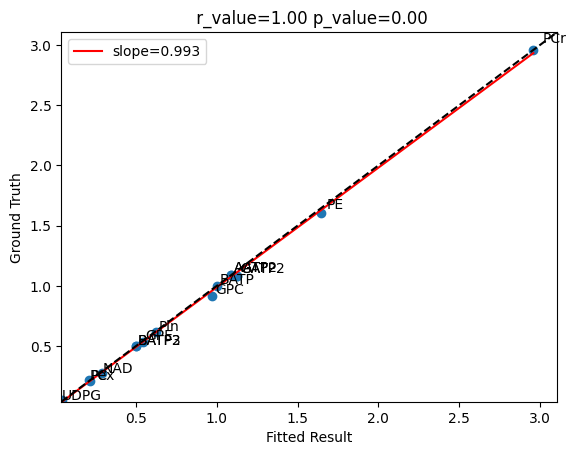

(np.float64(0.9925542146802476),
 np.float64(0.9996030113103711),
 np.float64(4.162283266904216e-23))

In [33]:
compare_plot(
    y=origin[amplitude_index]["value"],
    x=result1[amplitude_index]["value"],
    labellist=FIDresult1.peaklist,
    xlabel="Fitted Result",
    ylabel="Ground Truth",
)

Slope: 0.993
Pearson's R: 0.9996
P-value: 4.16e-23


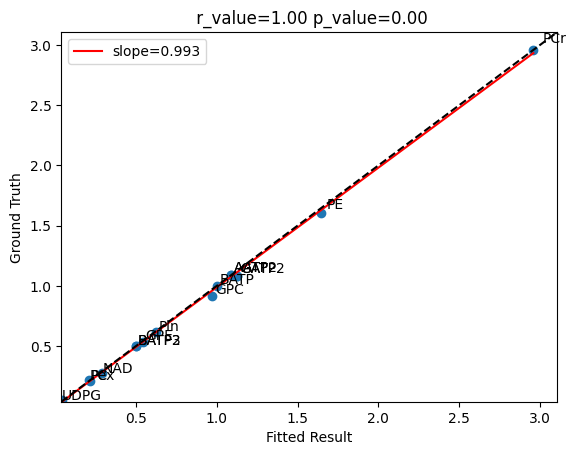

(np.float64(0.9925536981642361),
 np.float64(0.9996030122802171),
 np.float64(4.162212098626066e-23))

In [34]:
compare_plot(
    x=result2[amplitude_index]["value"],
    y=origin[amplitude_index]["value"],
    labellist=FIDresult1.peaklist,
    xlabel="Fitted Result",
    ylabel="Ground Truth",
)

Slope: 0.993
Pearson's R: 0.9996
P-value: 4.16e-23


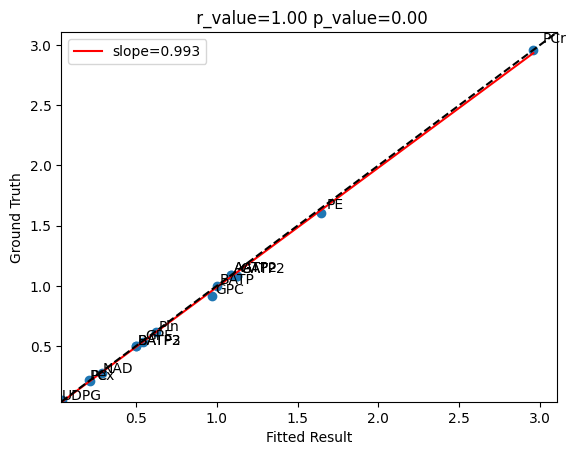

(np.float64(0.992553702276712),
 np.float64(0.9996030122938729),
 np.float64(4.162211096553134e-23))

In [35]:
compare_plot(
    x=result3[amplitude_index]["value"],
    y=origin[amplitude_index]["value"],
    labellist=FIDresult1.peaklist,
    xlabel="Fitted Result",
    ylabel="Ground Truth",
)